Install keras

In [18]:
!pip3 install keras

Download data and uncompress

In [19]:
!wget https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
!tar xvzf gender.tgz

--2021-04-19 10:22:10--  https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zcwlujrtz3izcw8/gender.tgz [following]
--2021-04-19 10:22:10--  https://www.dropbox.com/s/raw/zcwlujrtz3izcw8/gender.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc549b006df70610c78c4cac3d6.dl.dropboxusercontent.com/cd/0/inline/BM5JAMO7gRu6HyvV3zMZ573kvSWo2MKKtZfYdcZDn7MTu9VCz5Jw_OzguT_MRJFyRJTCcVSvrmvfCzxg7r3q4mmbWgWzYmOCIrj8ib8sODrzDsSu1yyWAwc7Myy5G52P3Rc-sxXkE_bMpVR8qcL_58XF/file# [following]
--2021-04-19 10:22:10--  https://ucc549b006df70610c78c4cac3d6.dl.dropboxusercontent.com/cd/0/inline/BM5JAMO7gRu6HyvV3zMZ573kvSWo2MKKtZfYdcZDn7MTu9VCz5Jw_OzguT_MRJFyRJTCcVSvrmvfCzxg7r3q4mmbWgWzYmOC

Import packages 

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

Define batch size, number of epochs and number of classes

In [35]:
batch_size = 128
epochs = 50
num_classes=2

Load and prepare data

(10585, 100, 100, 3)
(10585,)
2381
8204
0.2249
(2648, 100, 100, 3)
(2648,)
596
2052
0.2251


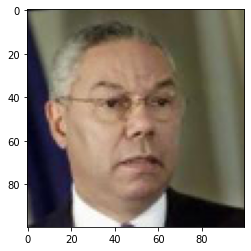

(10585, 100, 100, 3)
(2648, 100, 100, 3)


In [22]:
# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print("{:.4f}".format(sum(y_train == 1)/y_train.shape[0]))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))
print("{:.4f}".format(sum(y_test == 1)/y_test.shape[0]))


## View some images
plt.imshow(x_train[0,:,:,: ] )
plt.show()


## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)


num_classes = 2

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)


Create model, data augmentation etc... 

Data Augmentation with ImageGenerator

In [23]:
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=45,
    vertical_flip=True)

Define a convolutional block. Batch norm + Gaussian Norm + Max Pool

In [24]:
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(BN())
  model.add(GN(0.25))
  model.add(Activation('elu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  return model

Define the NN topology

In [62]:
## DEF NN TOPOLOGY  
model = Sequential()

model=CBGN(model,16,x_train.shape[1:])
model=CBGN(model,32)
model=CBGN(model,64)

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BN())
model.add(GN(0.1))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D((2,2), padding='same'))

model.add(Flatten())
model.add(Dense(16))
model.add(BN())
model.add(GN(0.1))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 100, 100, 16)      448       
_________________________________________________________________
batch_normalization_131 (Bat (None, 100, 100, 16)      64        
_________________________________________________________________
gaussian_noise_131 (Gaussian (None, 100, 100, 16)      0         
_________________________________________________________________
activation_154 (Activation)  (None, 100, 100, 16)      0         
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 50, 50, 32)        4640      
_________________________________________________________________
batch_normalization_132 (Bat (None, 50, 50, 32)      

Define an optimizer

In [63]:
sgd=SGD(lr=0.1, decay=0.0, momentum=0.0)

def scheduler(epoch):
  if epoch < epochs / 3:
    return 0.1
  elif epoch < epochs / 3 * 2:
    return 0.05
  else:
    return 0.02
set_lr = LRS(scheduler)

Compile the model, define loss and link the optimizer

In [64]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Model training and evaluation

In [ ]:
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)


score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
21/82 [======>.......................] - ETA: 17s - loss: 0.7791 - accuracy: 0.6149

In [ ]:
print(history.history.keys())

In [29]:
import matplotlib.pyplot as plt

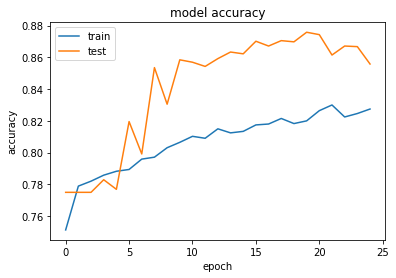

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()